In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.ticker import MaxNLocator
set1 = sns.color_palette('Set1')
sns.set_palette('Set1')

import requests
from bs4 import BeautifulSoup

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = "https://www.worldometers.info/coronavirus/"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')


t = soup.find(id="main_table_countries_today").text

a = np.array(t.strip().split("\n"))

b = a[153:]

columns = ['Country', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', '', '', 'Continent']
df = pd.DataFrame(np.split(b, range(15, len(b), 15)), columns=columns).iloc[:212]

def convert_float(field):
    field = field.replace(',', '')
    try:
        return float(field)
    except ValueError:
        return None

for c in ['TotCases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']:
    df[c] = df[c].apply(convert_float)

for c in ['TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests']:
    df[c] = df[c].apply(convert_float)
df.sort_values('TotalCases', ascending=False).head(20)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotCases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,,,Continent
174,Africa,1.305183e+11,NaN,NaN,87.0,NaN,NaN,116.0,NaN,34214.0,NaN,1153.0,,"32,210",
196,Africa,2.531041e+09,NaN,NaN,59.0,NaN,NaN,131.0,NaN,18815.0,NaN,141.0,,"18,650",
8,197,3.164237e+08,227344.0,1.391827e+09,NaN,5650724.0,0.4,NaN,2527.0,NaN,NaN,3.0,Brazil,"15,627,475",
14,"914,452",1.459891e+08,NaN,3.012601e+06,NaN,NaN,1838.0,NaN,NaN,7.0,NaN,4450777.0,,"127,679",
168,"22,558",4.699020e+07,NaN,1.098135e+11,NaN,NaN,10.0,NaN,NaN,112.0,NaN,40850.0,,"1,125",
96,431,4.674065e+07,8044847.0,5.810011e+06,NaN,2223220.0,NaN,NaN,2246.0,NaN,NaN,63.0,Ethiopia,"266,264",
80,"566,607",1.897229e+07,NaN,5.346582e+06,110.0,1.0,2023.0,NaN,NaN,52.0,NaN,350390.0,,"7,708",
146,"78,155",1.882977e+07,NaN,2.041494e+09,NaN,NaN,19.0,NaN,NaN,97.0,NaN,90105.0,,931,
36,"787,786",1.716799e+07,NaN,1.198410e+05,NaN,NaN,12297.0,NaN,NaN,22.0,NaN,1328582.0,,"24,948",
30,"1,984",1.209182e+07,362339.0,3.337156e+07,NaN,185043.0,NaN,NaN,3061.0,NaN,NaN,18.0,Indonesia,"1,739,750",


In [3]:
hun_list = []
page_i = 0
while True:
    try:
        t = pd.read_html(f"https://koronavirus.gov.hu/elhunytak/?page={page_i}")[0]
        page_i += 1
        hun_list.append(t)
    except ValueError:
        break
hun = pd.concat(hun_list)
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

# Általános statisztikák

In [4]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean().round(1))
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 29175
Átlagéletkor: 74.0
Medián életkor: 76.0
Életkor szórása: 12.3
Férfi: 4390, Nő: 1524


In [5]:
daily_stats = pd.read_table("daily_stats.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today()
if today.date() not in daily_stats.index:
    print("Adding today's stats")
    daily_stats.loc[today, "cnt"] = len(hun)
    daily_stats.loc[today, 'M'] = gc.loc['Férfi']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'M']
    daily_stats.loc[today, 'F'] = gc.loc['Nő']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'F']
    daily_stats.index = daily_stats.index.map(lambda i: i.date())
    
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    url = "https://koronavirus.gov.hu/"
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    for d in soup.find_all("div", class_="diagram-a"):
        label = d.find("span", class_="label").get_text()
        number = d.find("span", class_="number")
        if number:
            number = number.get_text().replace(" ", "")
            daily_stats.loc[today.date(), label] = int(number)
    daily_stats.to_csv("daily_stats.tsv", sep="\t")
daily_stats = daily_stats.rename(columns={'Fertőzött': 'case', 'Gyógyult': 'recovered'})

Adding today's stats


In [6]:
lineplot_kws = dict(marker='X', linewidth=3, markersize=10)

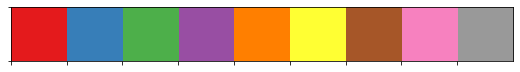

In [7]:
sns.palplot(sns.color_palette('Set1'))

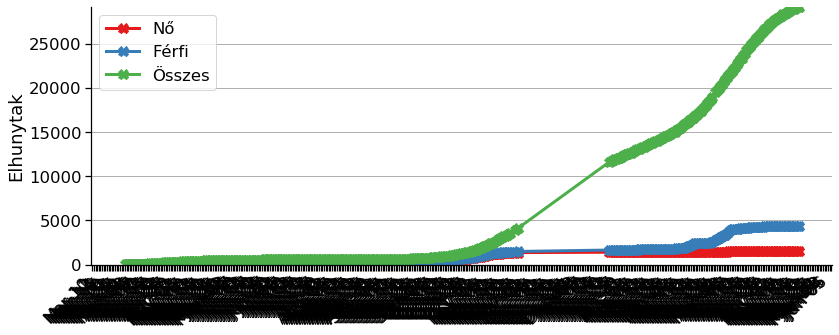

In [8]:
d = daily_stats.copy()
d = d.rename(columns={'M': 'Férfi', 'F': 'Nő', 'cnt': 'Összes'})
m = sns.color_palette('Set1')
cmap = [m[0], m[1], m[2]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Nő', 'Férfi', 'Összes'], color=cmap, ax=ax, **lineplot_kws)
    ax.set_ylim(0, len(hun)+5)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Elhunytak")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_death_count.png", dpi=200)

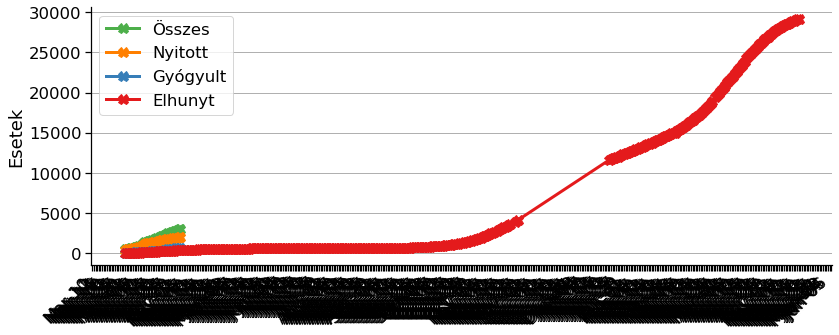

In [9]:
d = daily_stats.copy()
d = d.rename(columns={'recovered': 'Gyógyult', 'case': 'Összes', 'cnt': 'Elhunyt'})
d['Nyitott'] = d['Összes'] - d['Gyógyult'] - d['Elhunyt']
m = sns.color_palette('Set1')
cmap = [m[2], m[4], m[1], m[0]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Összes', 'Nyitott', 'Gyógyult', 'Elhunyt'], color=cmap, ax=ax, **lineplot_kws)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Esetek")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_all.png", dpi=200)

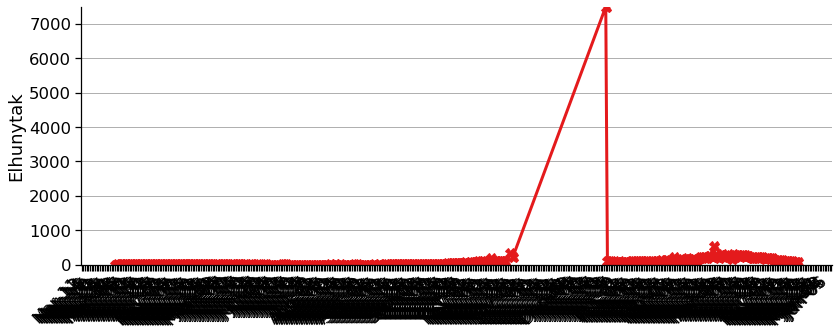

In [10]:
d = daily_stats.cnt.diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_new_deaths.png", dpi=200)

# Meggyógyult / elhunyt naponta

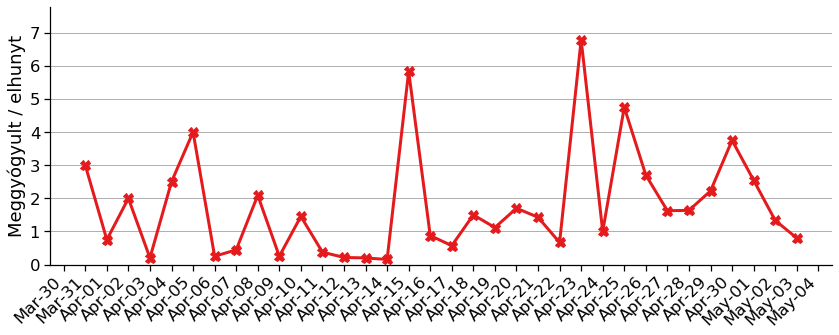

In [11]:
d = daily_stats[['cnt', 'recovered']].diff()
d['recovery/death'] = d['recovered'] / d['cnt']
d = d['recovery/death']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Meggyógyult / elhunyt")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_recovered_per_death.png", dpi=200)

In [12]:
daily_stats

,cnt,M,F,case,recovered,Hatósági házi karanténban,Mintavétel
day,,,,,,,
2020-03-30,15.0,NaN,NaN,447.0,34.0,NaN,NaN
2020-03-31,16.0,10.0,6.0,492.0,37.0,NaN,NaN
2020-04-01,20.0,12.0,8.0,525.0,40.0,NaN,NaN
2020-04-02,21.0,13.0,8.0,585.0,42.0,NaN,NaN
2020-04-03,26.0,16.0,11.0,623.0,43.0,NaN,NaN
...,...,...,...,...,...,...,...
2021-05-13,28888.0,4390.0,1524.0,NaN,NaN,NaN,NaN
2021-05-14,28970.0,4390.0,1524.0,NaN,NaN,NaN,NaN
2021-05-15,29041.0,4390.0,1524.0,NaN,NaN,NaN,NaN


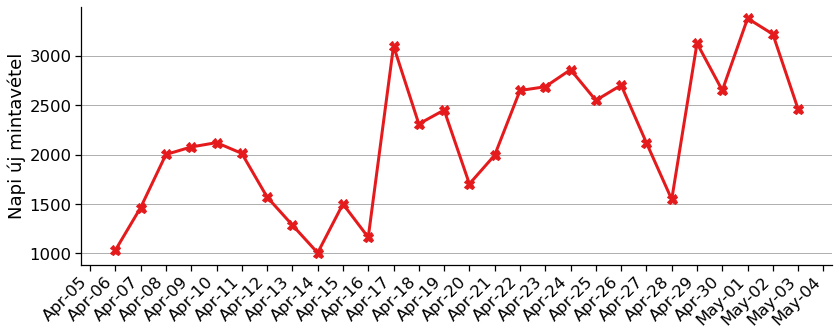

In [13]:
d = daily_stats['Mintavétel'].diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Napi új mintavétel")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_tests_per_day.png", dpi=200)

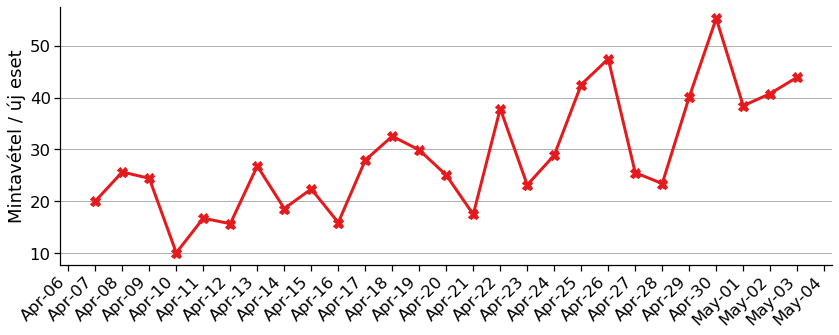

In [14]:
d = daily_stats[['case', 'Mintavétel']].diff()
d['Mintavétel/új eset'] = d['Mintavétel'] / d['case']
d = d['Mintavétel/új eset']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.dropna().iloc[1:].plot(ax=ax, **lineplot_kws)
    #ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Mintavétel / új eset")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_test_per_case.png", dpi=200)

# Korosztályonként

In [15]:
labels = ['40 alatt', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', '90 felett']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

In [16]:
barplot_kws = dict(alpha=0.8, color=sns.color_palette('Set1')[2], zorder=3)

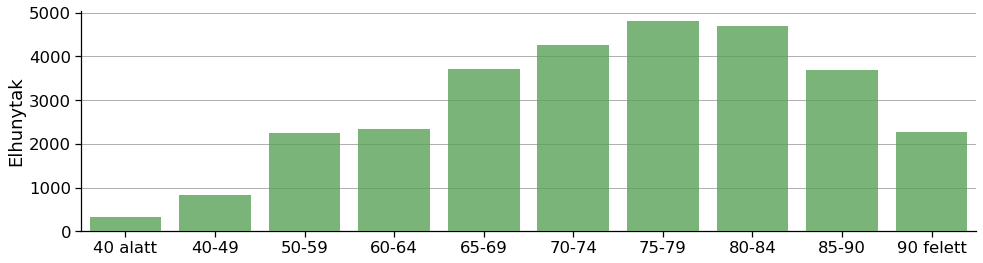

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    sns.countplot(hun.age_group, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    ax.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group.png", dpi=200)

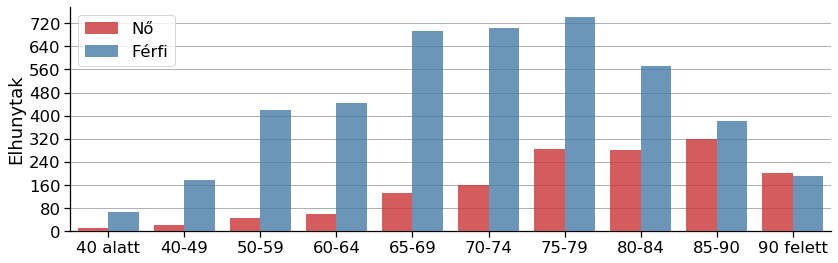

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax, hue_order=['Nő', 'Férfi'],
                palette=[set1[0], set1[1]], **barplot_kws)
    ax.legend(title="", loc='upper left', fancybox=True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group_and_gender.png", dpi=200)

# Alapbetegségek

In [19]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []
norm_map = {
    "anyagcsere és daganatos betegség": "anyagcsere betegség, daganatos betegség",
    "szív- és veseelégtelenség": "szívelégtelenség, veseelégtelenség",
}

def split_conditions(conditions):
    conditions = conditions.strip()
    cnt = 0
    if conditions in ("adat feltöltés alatt", "adatok feltöltése folyamatban", "adat feltöltése folyamatban", "nincs adat", "adatok feltöltés alatt"):
        return None
    conditions = conditions.replace("\xa0", " ")
    for src, tgt in norm_map.items():
        conditions = conditions.replace(src, tgt)
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        cnt += 1
    return cnt
        
hun['condition_count'] = hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)
all_cond = set(categories.condition.values)
for c in categories.category.unique():
    if c not in all_cond:
        categories = categories.append(pd.Series({'condition': c, 'category': c}), ignore_index=True)

conditions = conditions.merge(categories, on='condition', how='left')

# Alapbetegségek száma

Hány olyan elhunyt van, akinek 0, 1 vagy több alapbetegsége van.

In [20]:
cond_cnt = hun.condition_count.value_counts(dropna=False).sort_index()
cond_cnt['NA'] = cond_cnt.loc[np.nan]

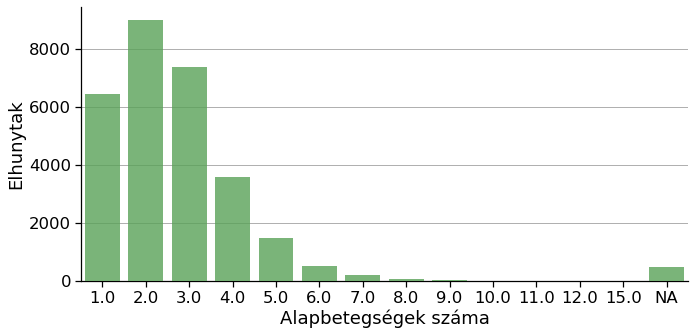

In [21]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #sns.countplot(hun.condition_count, ax=ax, **barplot_kws)
    sns.barplot(x=cond_cnt.index, y=cond_cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("Alapbetegségek száma")
    sns.despine()
    ax.grid(axis='y', zorder=0)
    plt.tight_layout()
    fig.savefig("fig/condition_histogram.png", dpi=200)

# 10 leggyakoribb betegség

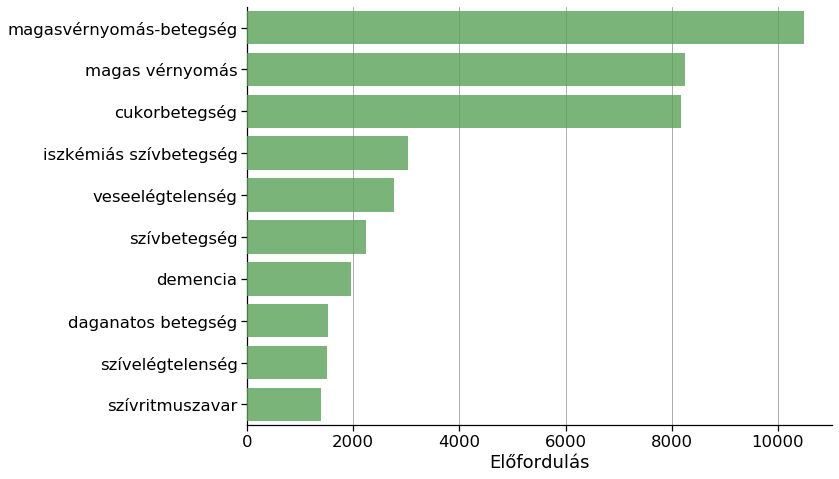

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.set_xlabel("Előfordulás")
    ax.grid(axis='x')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_most_common_diseases.png", dpi=200)

# Kategóriák

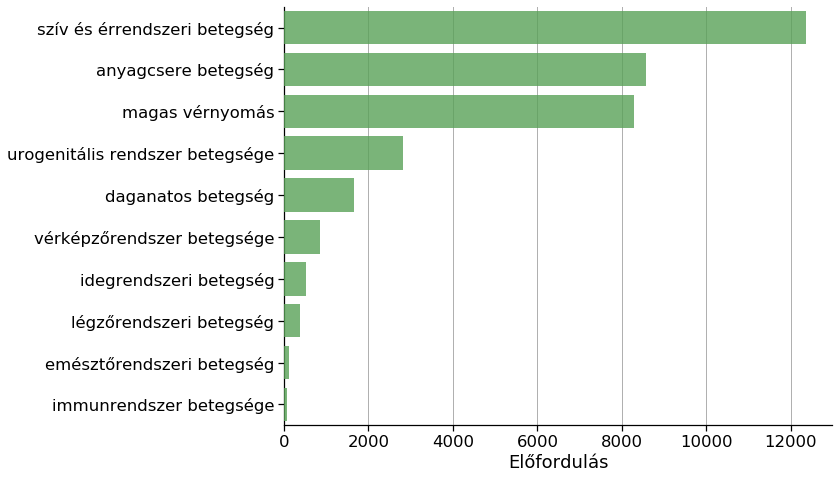

In [23]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.groupby('category')['cnt'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=common.index, x=common, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.grid(axis='x')
    ax.set_xlabel("Előfordulás")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_icd.png", dpi=200)

In [24]:
print("\n".join(conditions[conditions.category.isnull()].condition))

magasvérnyomás-betegség
korábban szívinfarktus
szívinfarktus
húgyhólyag rosszindulatú daganata
rekeszizomsérv
reflux
nem ismert alapbetegség
szívnagyobbodás
kóros elhízás
köszvény
rendszeres pszichiátriai gondozás
depresszió
érszûkület
vesebetegség
epehólyag eltávolítása
húgyúti fertõzés
veseelgennyesedés
pajzsmirigy-alulmûködés
végbélrák
májcirrózis
demencia
agykárosodás
általános érszûkület
tüdõtágulat
pajzsmirigybetegség
vastagbélgyulladás
mozgásszervi panaszok
húgyhólyagdaganat
prosztata megnagyobbodás
skizofrénia
idült iszkémiás szívbetegség
agyérbetegség
csontritkulás
szorongás
jobb alsó végtagi érszûkület
neurológiai betegség
zsírmáj
szívgyengeség
krónikus szívbetegség
végbéldaganat
krónikus tüdõbetegség
krónikus szívelégtelenség
policisztás vesebetegség
obstruktív tüdõbetegség
elhízás
Parkinson-kór
asztma
obsturktív tüdõbetegség
hasnyálmirigyrák
keringési elégtelenség
akut veseelégtelenség
máj rosszindulatú daganata
trombózis
magasvérnyomás- betegség
Down-szindróma
pajzsmirigy 